In [54]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import math
import os

In [55]:
# ==========================================
# 1. KONFIGURASI
# ==========================================
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 16  # KECILKAN Batch Size agar update bobot lebih sering
EPOCHS = 40      # Tambah Epoch karena learning rate kecil
LEARNING_RATE = 0.00005 # Sangat kecil agar belajar pelan-pelan

train_dir = 'Dataset/Training'
test_dir = 'Dataset/Testing'

In [56]:
# ==========================================
# 2. DATA GENERATOR (AUGMENTASI EKSTREM)
# ==========================================
# Kita perlu "mempersulit" data latih agar model tidak cepat puas
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,      # Putar lebih banyak
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,         # Zoom lebih variatif
    horizontal_flip=True,
    vertical_flip=True,     # Tambah flip vertikal
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

print("Menyiapkan Data...")
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Menyiapkan Data...
Found 108 images belonging to 2 classes.


Found 100 images belonging to 2 classes.


In [57]:
# ==========================================
# 3. ARSITEKTUR CNN (ULTRA-SIMPLE)
# ==========================================
def build_micro_cnn():
    model = Sequential()
    model.add(Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)))

    # --- Layer 1: Ekstraksi Fitur Kasar ---
    # Filter sedikit (16) + L2 Regularizer (mencegah bobot meledak)
    model.add(Conv2D(16, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))

    # --- Layer 2: Ekstraksi Fitur Halus ---
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))

    # --- Layer 3: Fitur Akhir ---
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))

    # Global Average Pooling (Lebih stabil daripada Flatten untuk data sedikit)
    model.add(GlobalAveragePooling2D()) 
    
    # --- Classifier ---
    model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.6)) # Matikan 60% neuron (sangat agresif)
    
    # Output
    model.add(Dense(1, activation='sigmoid'))

    return model

model = build_micro_cnn()

In [58]:
# ==========================================
# 4. TRAINING
# ==========================================
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Hitung bobot kelas (jika data tidak seimbang 50:50)
from sklearn.utils import class_weight
cls_train = train_generator.classes
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(cls_train),
    y=cls_train
)
weights_dict = dict(enumerate(class_weights))
print(f"Bobot Kelas Penyeimbang: {weights_dict}")

if 'train_generator' in locals():
    print("\nMulai Training Custom CNN...")
    history = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        validation_data=test_generator,
        validation_steps=len(test_generator),
        epochs=EPOCHS,
        verbose=2,
        class_weight=weights_dict # Paksa model memperhatikan kelas minoritas
    )

Bobot Kelas Penyeimbang: {0: np.float64(1.0), 1: np.float64(1.0)}

Mulai Training Custom CNN...


c:\Users\ROG FLOWX13\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
7/7 - 18s - 3s/step - accuracy: 0.6759 - loss: 1.7674 - val_accuracy: 0.5000 - val_loss: 1.8176
Epoch 2/40
7/7 - 18s - 3s/step - accuracy: 0.6759 - loss: 1.7674 - val_accuracy: 0.5000 - val_loss: 1.8176
Epoch 2/40
7/7 - 13s - 2s/step - accuracy: 0.6389 - loss: 1.7639 - val_accuracy: 0.5000 - val_loss: 1.8155
Epoch 3/40
7/7 - 13s - 2s/step - accuracy: 0.6389 - loss: 1.7639 - val_accuracy: 0.5000 - val_loss: 1.8155
Epoch 3/40
7/7 - 15s - 2s/step - accuracy: 0.7130 - loss: 1.6702 - val_accuracy: 0.5000 - val_loss: 1.8134
Epoch 4/40
7/7 - 15s - 2s/step - accuracy: 0.7130 - loss: 1.6702 - val_accuracy: 0.5000 - val_loss: 1.8134
Epoch 4/40
7/7 - 14s - 2s/step - accuracy: 0.7963 - loss: 1.6539 - val_accuracy: 0.5000 - val_loss: 1.8113
Epoch 5/40
7/7 - 14s - 2s/step - accuracy: 0.7963 - loss: 1.6539 - val_accuracy: 0.5000 - val_loss: 1.8113
Epoch 5/40
7/7 - 14s - 2s/step - accuracy: 0.7500 - loss: 1.6600 - val_accuracy: 0.4700 - val_loss: 1.8091
Epoch 6/40
7/7 - 14s - 2s/step - accu

KeyboardInterrupt: 

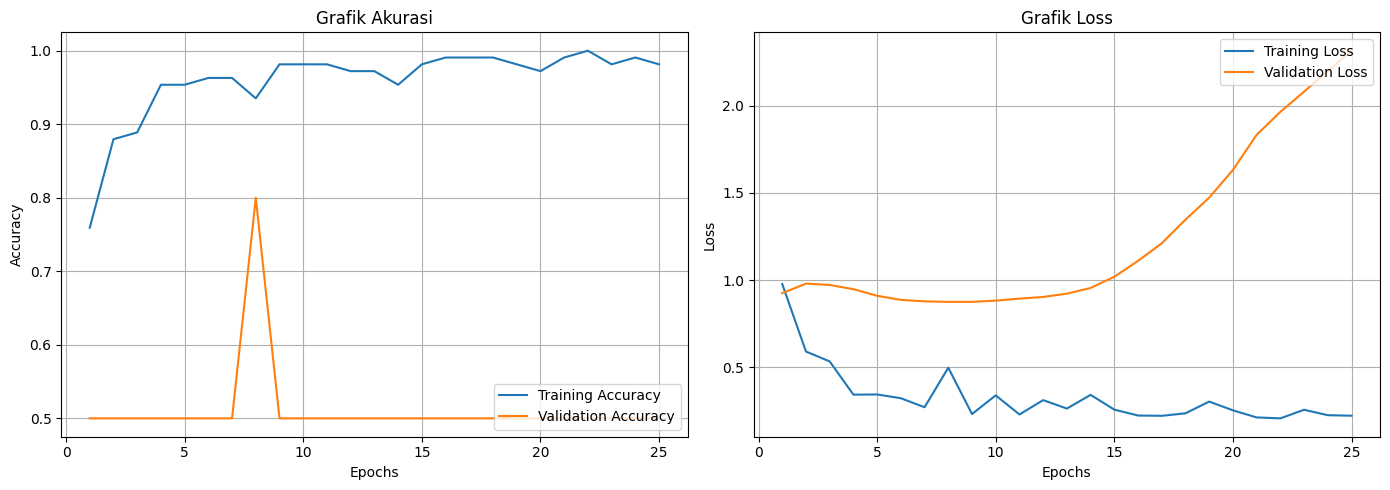

In [ ]:
# ==========================================
# 5. VISUALISASI
# ==========================================
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Acc')
plt.plot(epochs_range, val_acc, label='Val Acc')
plt.title('Akurasi')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.title('Loss')
plt.legend()
plt.grid(True)
plt.show()


Sedang membuat Confusion Matrix...
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step


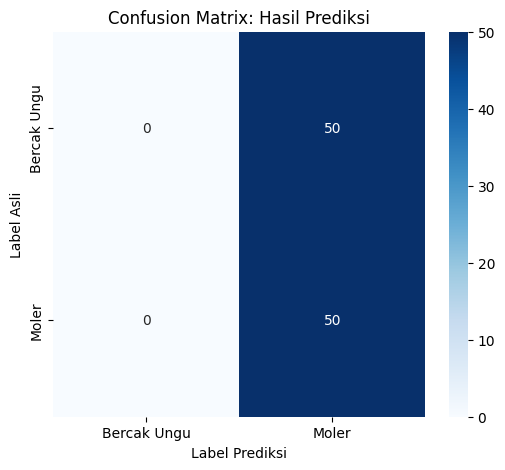


Laporan Detail:
              precision    recall  f1-score   support

 Bercak Ungu       0.00      0.00      0.00        50
       Moler       0.50      1.00      0.67        50

    accuracy                           0.50       100
   macro avg       0.25      0.50      0.33       100
weighted avg       0.25      0.50      0.33       100



c:\Users\ROG FLOWX13\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ROG FLOWX13\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ROG FLOWX13\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

In [ ]:
# ==========================================
# 6. CONFUSION MATRIX
# ==========================================
print("\nEvaluasi Akhir...")
test_generator.reset()
predictions = model.predict(test_generator)
y_pred = (predictions > 0.5).astype(int).ravel()
y_true = test_generator.classes
labels = list(train_generator.class_indices.keys())

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Prediksi')
plt.ylabel('Asli')
plt.show()

print(classification_report(y_true, y_pred, target_names=labels))